# Artificial Intelligence II: Project 2
### Sentiment Classification using Feed Forward Neural Networks
> Fall Semester 2022-2023

> Stylianos Oikonomou | 1115201500243

## Import Libraries

In [ ]:
import io
import requests

import re
import numpy as np
import pandas as pd
from pandas import DataFrame

# Stemming / Lemmatizing
# import nltk
# nltk.download('wordnet')
# nltk.download('omw-1.4')
# from nltk.stem.porter import PorterStemmer
# from nltk.stem import WordNetLemmatizer
# stemmer = PorterStemmer()
# lemmatizer = WordNetLemmatizer()
# Neural Network
import torch
import torch.nn as nn
import copy
# Scoring
from sklearn import metrics
from sklearn.metrics import f1_score, recall_score, precision_score
# Stopwords
import nltk.corpus
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = stopwords.words('english')
# Plotting / Results
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt

# Settings
pd.set_option('max_colwidth', 10000)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load Reviews


In [ ]:
# Google Drive file ID from the shared link
file_id = '17K9rHy6iajoUW_IKDBwKE2LwajZzu1hV'
# Download URL for the file
download_url = f'https://drive.google.com/uc?id={file_id}'
# Fetch the content of the file
response = requests.get(download_url).content

In [ ]:
# Read the content into a pandas DataFrame
dataFrames = pd.read_csv(io.StringIO(response.decode('utf-8')), sep = '\t')
# Drop the "url" column from the dataFrame
dataFrames = dataFrames.drop(["url"], axis=1)
# Change the column order for better readability
dataFrames = dataFrames.loc[:, ["review", "rating"]]

In [ ]:
# Check if there are any Null fields in the data
dataFrames.isnull().sum()

review    0
rating    0
dtype: int64

In [ ]:
dataFrames.head()

,review,rating
0,I thought this was a quiet good movie. It was fun to watch it. What I liked best where the 'Outtakes' at the end of the movie. They were GREAT.,10.0
1,"Wagon Master is a very unique film amongst John Ford's work. Mainly because it's the only one that is based on a story written by John Ford himself, the story that was elaborated by Frank Nugent and director's son  Patrick Ford and turned into a screenplay, and because of director's personal opinion regarding it, Wagon Master is the film John Ford called the one which `came closest to being what I had wanted to achieve', to say so is not to say a little, but as Ford confessed once to Lindsay Anderson, his favourite was nonetheless My Darling Clementine and not any other.<br /><br /> Wagon Master has all ingredients one might expect to find in a John Ford's film. Wonderful cast delivering his best, thou not featuring any major stars, except the most `fordian' of all actors  Ben Johnson. Very peculiar small characters, who provide an obligatory comic relief, and Wagon Master has quite a few of them such as horn blowing Sister Ledyard (Jane Darwell) in her shot but very inspired gigs. And last but not least legendary Monument Valley with John Ford's fifth passage through it after Stagecoach, My Darling Clementine, Fort Apache and She Wore a Yellow Ribbon.<br /><br /> The film starts with two friends cowboys Travis Blue (Ben Johnson) and Sandy Owens (Harry Carey Jr) being hired to be Wagon Masters or guides for a caravan of Mormon settlers who are headed to Silver Valley, a place that's for them like a promised land. On their way they are joined by a very peculiar Dr. Locksley Hall (Alan Mowbray) with two beautiful women, who are supposedly his wife and daughter and who call themselves actors. They are headed in the same direction simply because they were recently driven out of the nearest town and have no other place to go. Nothing particularly unpleasant happens till they bump into Cleggs, a dangerous family gang consisting of father and his three sons who are on the run from the Marshal of the town where they recently committed murder and bank robbery.<br /><br /> Overall Wagon Master is no more nor less than one more precious pearl in a necklace of John Ford's wonderful Westerns. A must see. 9/10<br /><br />",9.0
2,"This film has to be as near to perfect a film as John Ford made. The film is magic, a masterpiece, the reason Ford was, well Ford. If you want to know why Ford was great this one explains it.<br /><br />The photography of course is superb, black and white as black and white should be, wonderful shots, not an over the shoulder conversation in it, pure Ford, great moments, big and little. The famous ripped pants of Ward Bond. Apparently two dogs kept invading the set and fighting so Ford wanted to use them in the fighting scene, but instead of fighting one dog ran away and the other attacked Ward Bond and ripped his pants, which caused Ford no end of mirth. A whole scene around plaiting a rope. The way Ben Johnson burn then snuffs his rope, wonderful foreshadowing and anticipation of the final. Harry Carey's naive courting of Prudence. The usual ford line about being scared and not showing it. Bond's horse accidentally falling in him and its left in the film. Johnson and Bond are fantastic in that scene. Lord help any Ford actor who does not stay in character while the camera is rolling even when a horse falls on top of you.<br /><br />A couple of very sweet romances, not intruding on the whole focus, two very likable leads, not to mention for the girls, the number of times the cameras focus on Ben Johnson's rather delightful backside.<br /><br />Lots of old time stuntmen getting lines and roles, Cliff Lyons, Frank McGrath. Some wonderful character studies mostly of faces staring, all the villains and main stars. A set of villains to rival any group in any western.<br /><br />Many many Fordian shots of faces, groups, children, women, small things ha

## Download GloVe Embeddings

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

## Transform GloVe embeddings to Word2Vec format

In [ ]:
from gensim.scripts.glove2word2vec import glove2word2vec
import pandas as pd

glove_input_file = 'glove.6B.50d.txt'
w2v_output_file = 'glv_with_w2v_format.txt'

glove2word2vec(glove_input_file, w2v_output_file)

<ipython-input-10-d5069a0ef93c>:8: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input_file, w2v_output_file)


(400000, 50)

## Create GloVe embeddings Dictionary

In [ ]:
with open(w2v_output_file, 'r') as infile:
    w2v = infile.read().splitlines()

dict_word_count = int(w2v[0].split()[0])
feature_count = int(w2v[0].split()[1])

w2v_dict = {}

for word_vector_pair in w2v[1:]:
    word_vector_pair = word_vector_pair.split()

    word = word_vector_pair[0]
    vector = word_vector_pair[1:]

    w2v_dict[word] = list(map(float, vector))

## Preprocessing

In [ ]:
reviews = dataFrames.drop(["rating"], axis=1)
ratings = dataFrames.drop(["review"], axis=1)

Classify ratings

In [ ]:
def classifyRating(rating) :
  if rating >= 7 :
    return 1
  else :
    return 0

In [ ]:
classified_ratings = ratings.applymap(classifyRating)

Clean up reviews

In [ ]:
def cleanReview(review):
  review = re.sub(r'<[ a-z/]*>', ' ', review)                                   # Remove left-over HTML Tags
  review = re.sub(r'[a-zA-Z0-9]*[0-9][a-zA-Z0-9]*', ' ', review)                # Remove numbers
  review = re.sub(r'[^`\'a-zA-Z]', ' ', review)                                 # Remove all non letter
  review = re.sub(r'( [\'`]|[\'`] |`s |\'s )', ' ', review)                     # Clean apostrophe
  review = re.sub(r'\s+', ' ', review)                                          # Remove multiple white-spaces
  review = review.casefold()                                                    # Turn all letters to lower case
  review = [word for word in review.split() if word not in (stop)]              # Remove stop words
  # review = [stemmer.stem(word) for word in review if word not in (stop)]            # Remove stop words and use stemming
  # review = [lemmatizer.lemmatize(word) for word in review if word not in (stop)]    # Remove stop words and use lemmatizing
  return review

In [ ]:
cleaned_reviews = reviews.applymap(cleanReview)

In [ ]:
example = 15
# Before clean-up
print('Before :', reviews.iloc[example].to_string(index=False), end='\n\n')
# After clean-up
print('After  :', cleaned_reviews.iloc[example].to_string(index=False))

Before : ****Excellent<br /><br />***Good<br /><br />**Fair<br /><br />*Poor<br /><br />`Go Ahead, make my Day!' <br /><br />The fourth picture in the series is directed by Eastwood himself (Who was rumored of directing most of Magnum Force) and he brings back the violent society from the first two films. However, the film still lacks impact and believability. This film was released in the early `80s, the time of Regan and the young republicans. The premise of a raped woman taking vengeance on her rapist doesn't appeal to this time frame. This plot would have been better for the Enforcer, which actually would have made it a good movie. What Sudden Impact needed was a plot like in Wall Street but with Dirty Harry in the middle. <br /><br />RATING: 3 STARS

After  : [excellent, good, fair, poor, go, ahead, make, day, fourth, picture, series, directed, eastwood, rumored, directing, magnum, force, brings, back, violent, society, first, two, films, however, film, still, lacks, impact, belie

Create features using word embendings

In [ ]:
def reviewEmbending(review):
  # Number of review words that exist in the w2v dictionary
  review_words = len(review)
  # Collect the word embendings
  emb = [[0] * feature_count]
  for word in review:
    if word in w2v_dict:
      emb.append(w2v_dict[word])
    else:
      review_words -= 1
  # Calcualte the sum
  emb_sum = [sum(x) for x in zip(*emb)]
  # If there is at least one valid word return the mean of the embendings, return a 0 initialized list otherwise
  if review_words != 0:
    emb_mean = [x/review_words for x in emb_sum]
    return emb_mean
  else:
    return [0] * feature_count

In [ ]:
review_embendings = cleaned_reviews.applymap(reviewEmbending)

In [ ]:
example = 0
# Before creating embendings
print('Before :', cleaned_reviews.iloc[example].to_string(index=False), end='\n\n')
# After creating embendings
print('After  :', review_embendings.iloc[example].to_string(index=False))

Before : [thought, quiet, good, movie, fun, watch, liked, best, outtakes, end, movie, great]

After  : [-0.01131125, 0.308282775, -0.33072616666666665, -0.1616566666666667, 0.4315393333333333, -0.21488199166666674, -0.5082691666666667, -0.15193691666666664, -0.28636858333333337, 0.5717436666666667, -0.4672585, 0.3048845, -0.32103125, 0.26473183333333333, 0.76122075, -0.0008815000000000096, 0.44614674999999987, 0.26318441666666664, -0.4006438666666667, -0.4240899999999999, 0.08421841666666664, 0.5933244166666666, 0.24736166666666662, 0.232351, 0.6218233333333333, -1.1158858333333332, -0.9645269166666665, 0.216471, 0.5561141666666666, -0.4533933333333333, 2.6088899999999997, 0.2800539166666667, 0.13664695333333332, -0.21371516666666665, 0.03433516666666665, 0.2179195833333333, 0.04596965000000001, 0.12971166666666667, -0.35879749999999994, -0.5436981666666667, -0.17911091666666668, 0.33089168333333335, -0.30009645833333326, 0.07215583333333334, -0.08951333333333333, 0.07953975, 0.0916230

## Split sets

In [ ]:
x = torch.tensor(review_embendings['review'], dtype=torch.float)
y = torch.tensor(classified_ratings.values, dtype=torch.float)

print(f"x shape: {x.shape}")
print(f"y shape: {y.shape}")

x shape: torch.Size([45008, 50])
y shape: torch.Size([45008, 1])


In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, train_size=0.8, random_state=69)

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_valid shape: {x_valid.shape}")
print(f"y_valid shape: {y_valid.shape}")

x_train shape: torch.Size([36006, 50])
y_train shape: torch.Size([36006, 1])
x_valid shape: torch.Size([9002, 50])
y_valid shape: torch.Size([9002, 1])


In [ ]:
# Clear up some space
del dataFrames, w2v_dict, reviews, ratings
del classified_ratings, review_embendings     # Make comment to rerun with different train, val set sizes

## Create a Neural Network

In [ ]:
class Net(nn.Module):
    def __init__(self, D_in, H1, H2, H3, D_out):
        super(Net, self).__init__()

        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, H3)
        self.linear4 = nn.Linear(H3, D_out)

        self.relu=nn.ReLU()
        self.sigm=nn.Sigmoid()

    def forward(self, x):
        h1  = self.linear1(x)
        h2  = self.relu(self.linear2(h1))
        h3  = self.relu(self.linear3(h2))
        out = self.sigm(self.linear4(h3))
        return out

In [ ]:
#Define layer sizes
D_in = x.shape[1]
H1 = 128
H2 = 64
H3 = 32
D_out = 1

#Define Hyperparameters
learning_rate = 0.0001
batchSize = 64

#Initialise model, loss, optimizer
model = Net(D_in, H1, H2, H3, D_out)
loss_func = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#Initialise dataloader
dataset = torch.utils.data.TensorDataset(x_train, y_train)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchSize, shuffle=True)

In [ ]:
model

Net(
  (linear1): Linear(in_features=50, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=32, bias=True)
  (linear4): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (sigm): Sigmoid()
)

## Train Network

In [ ]:
train_set_predict = []
valid_set_predict = []
train_set_loss = []
valid_set_loss = []

Set up early stopping parameters

In [ ]:
patience = 5
loss_diff_limit = 0.001

In [ ]:
epochs = 100

for epoch in range(epochs):
  batch_losses = []

  for x_batch, y_batch in dataloader:
    y_pred = model(x_batch)

    loss = loss_func(y_pred, y_batch)
    # batch_losses.append(loss.item())

    #Delete previously stored gradients
    optimizer.zero_grad()
    #Perform backpropagation starting from the loss calculated in this epoch
    loss.backward()
    #Update model's weights based on the gradients calculated during backprop
    optimizer.step()

  train_set_predict.append(model(x_train))
  train_set_loss.append(float(loss_func(train_set_predict[-1], y_train)) / x_train.shape[0])
  valid_set_predict.append(model(x_valid))
  valid_set_loss.append(float(loss_func(valid_set_predict[-1], y_valid)) / x_valid.shape[0])

  # Early Stopping
  # If the epoch is greater than one...
  # and the difference is above the loss_diff_limit parameter or the valid set loss has increased...
  # then if these conditions have been validated as many times as the patience parameter then stop the training and restore the last best model
  if (epoch > 1 and (abs(train_set_loss[-1] - valid_set_loss[-1]) > loss_diff_limit or valid_set_loss[-1] > valid_set_loss[-2]) ):
    earlyStop_count += 1
    if earlyStop_count == 1:
      model_clone = copy.deepcopy(model)
    if earlyStop_count == patience:
      train_set_predict=train_set_predict[:-patience]
      valid_set_predict=valid_set_predict[:-patience]
      train_set_loss=train_set_loss[:-patience]
      valid_set_loss=valid_set_loss[:-patience]
      model = copy.deepcopy(model_clone)
      last_epoch = epoch - patience + 1
      break
  else:
    earlyStop_count = 0

  last_epoch = epoch + 1

  print(f"Epoch {epoch:3}: T_Loss = {train_set_loss[-1]:.5f} | V_Loss = {valid_set_loss[-1]:.5f} | Diff = {abs(valid_set_loss[-1] - train_set_loss[-1]):.5f} | ", end="")
  if earlyStop_count > 0:
    print(f"earlyStop_count = {earlyStop_count}")
  else:
    print()

Epoch   0: T_Loss = 0.18617 | V_Loss = 0.18451 | Diff = 0.00167 | 
Epoch   1: T_Loss = 0.17275 | V_Loss = 0.17171 | Diff = 0.00104 | 
Epoch   2: T_Loss = 0.16811 | V_Loss = 0.16722 | Diff = 0.00089 | 
Epoch   3: T_Loss = 0.16718 | V_Loss = 0.16684 | Diff = 0.00034 | 
Epoch   4: T_Loss = 0.16597 | V_Loss = 0.16578 | Diff = 0.00019 | 
Epoch   5: T_Loss = 0.16666 | V_Loss = 0.16627 | Diff = 0.00038 | earlyStop_count = 1
Epoch   6: T_Loss = 0.16505 | V_Loss = 0.16517 | Diff = 0.00012 | 
Epoch   7: T_Loss = 0.16516 | V_Loss = 0.16546 | Diff = 0.00030 | earlyStop_count = 1
Epoch   8: T_Loss = 0.16466 | V_Loss = 0.16497 | Diff = 0.00031 | 
Epoch   9: T_Loss = 0.16431 | V_Loss = 0.16455 | Diff = 0.00024 | 
Epoch  10: T_Loss = 0.16412 | V_Loss = 0.16438 | Diff = 0.00026 | 
Epoch  11: T_Loss = 0.16393 | V_Loss = 0.16419 | Diff = 0.00026 | 
Epoch  12: T_Loss = 0.16400 | V_Loss = 0.16440 | Diff = 0.00040 | earlyStop_count = 1
Epoch  13: T_Loss = 0.16355 | V_Loss = 0.16386 | Diff = 0.00031 | 
Epoch

## Results

Learning and ROC curves

In [ ]:
train_fpr, train_tpr, Tthr = metrics.roc_curve(y_train.detach().numpy(), train_set_predict[-1].detach().numpy())
valid_fpr, valid_tpr, Vthr = metrics.roc_curve(y_valid.detach().numpy(), valid_set_predict[-1].detach().numpy())

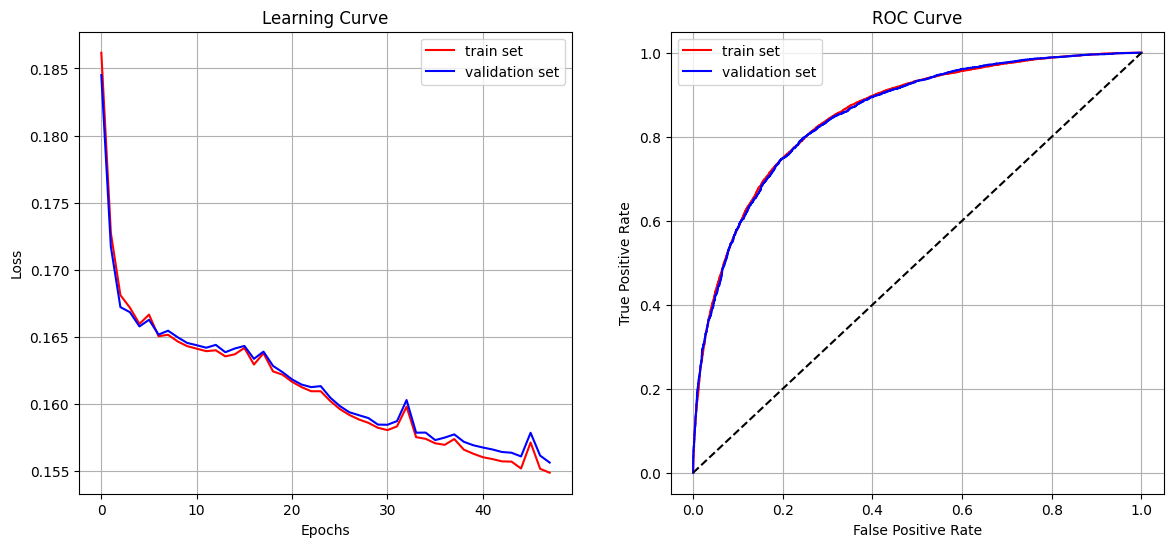

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.set_title('Learning Curve')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.plot(range(last_epoch), train_set_loss, 'r', label='train set')
ax1.plot(range(last_epoch), valid_set_loss, 'b', label='validation set')
ax1.grid()
ax1.legend(loc="best")

ax2.set_title('ROC Curve')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.plot(train_fpr, train_tpr, 'r', label='train set')
ax2.plot(valid_fpr, valid_tpr, 'b', label='validation set')
ax2.plot(np.arange(0.0, 1.1, 0.1), np.arange(0.0, 1.1, 0.1), '--k')
ax2.grid()
ax2.legend(loc="best")

fig.show()

F1, Recall, Precision scores

In [ ]:
# Classify predictions
for ep in range(last_epoch):
    train_set_predict[ep] = [0 if y < 0.5 else 1 for y in train_set_predict[ep]]
    valid_set_predict[ep] = [0 if y < 0.5 else 1 for y in valid_set_predict[ep]]

In [ ]:
# Calculate scores
f1_train = [f1_score(y_train.detach().numpy(), train_set_predict[ep], average='weighted') for ep in range(last_epoch)]
f1_valid = [f1_score(y_valid.detach().numpy(), valid_set_predict[ep], average='weighted') for ep in range(last_epoch)]

recall_score_train = [recall_score(y_train.detach().numpy(), train_set_predict[ep], average='weighted') for ep in range(last_epoch)]
recall_score_valid = [recall_score(y_valid.detach().numpy(), valid_set_predict[ep], average='weighted') for ep in range(last_epoch)]

precision_score_train = [precision_score(y_train.detach().numpy(), train_set_predict[ep], average='weighted') for ep in range(last_epoch)]
precision_score_valid = [precision_score(y_valid.detach().numpy(), valid_set_predict[ep], average='weighted') for ep in range(last_epoch)]

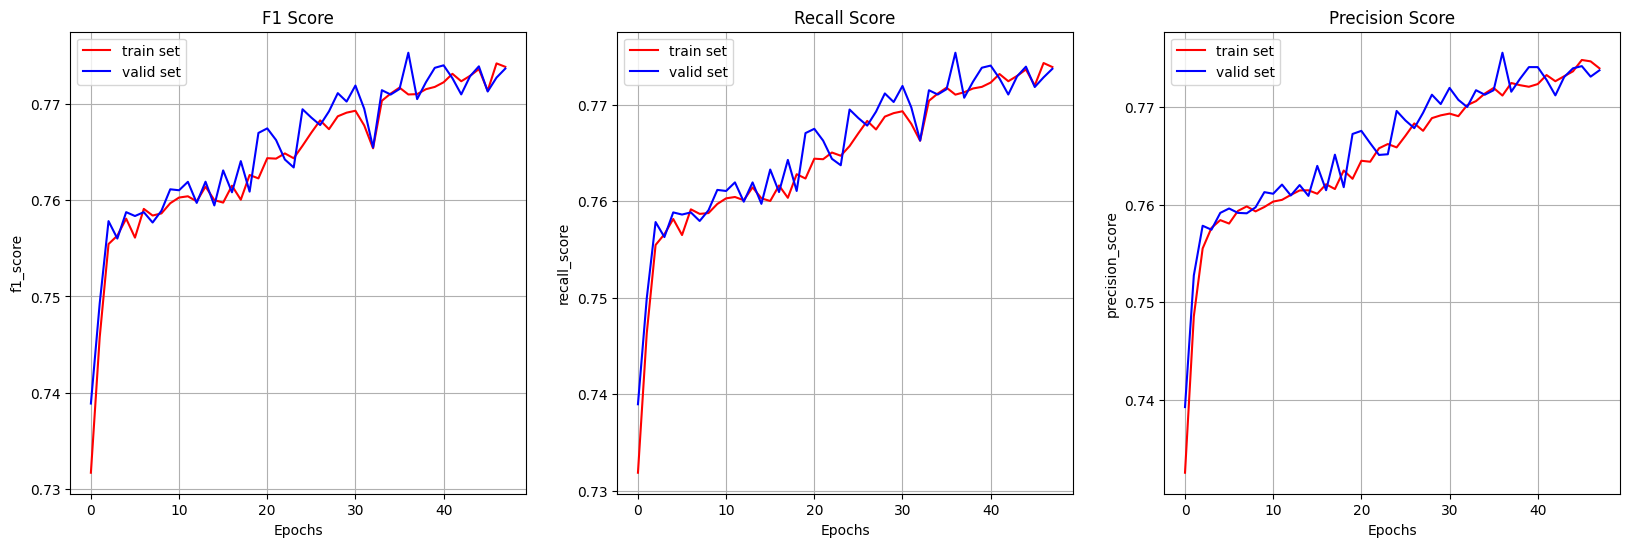

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

ax1.set_title('F1 Score')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('f1_score')
ax1.plot(range(last_epoch), f1_train, 'r', label='train set')
ax1.plot(range(last_epoch), f1_valid, 'b', label='valid set')
ax1.grid()
ax1.legend(loc="best")

ax2.set_title('Recall Score')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('recall_score')
ax2.plot(range(last_epoch), recall_score_train, 'r', label='train set')
ax2.plot(range(last_epoch), recall_score_valid, 'b', label='valid set')
ax2.grid()
ax2.legend(loc="best")

ax3.set_title('Precision Score')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('precision_score')
ax3.plot(range(last_epoch), precision_score_train, 'r', label='train set')
ax3.plot(range(last_epoch), precision_score_valid, 'b', label='valid set')
ax3.grid()
ax3.legend(loc="best")